In [3]:
import os
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread # Used to read images
from PIL import Image # Image Visulization

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

## Unzip File and Load Train Dataset into dataframe

In [8]:
train_path = "C:/Users/zhaox/Northwestern HW/CatDog/train.zip"
test_path = "C:/Users/zhaox/Northwestern HW/CatDog/test.zip"

files = "C:/Users/zhaox/Northwestern HW/CatDog"

# zipfile - python module for extracting files from a zip file
import zipfile

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)
    
with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

In [4]:
image_dir = "C:/Users/zhaox/Northwestern HW/CatDog/train/"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [5]:
data.label.value_counts()

cat    12500
dog    12500
Name: label, dtype: int64

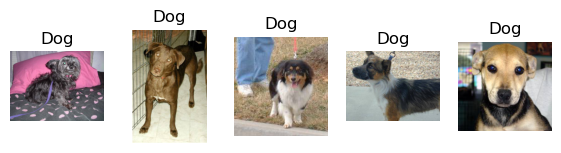

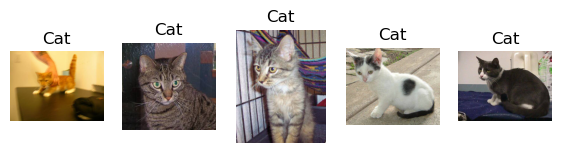

In [6]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(5):
    
    plt.subplot(10, 14,i+1)    # the number of images in the grid is 10*10 (100)
    filename = 'train/' + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()


plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(5):
    
    plt.subplot(10, 14,i+1)    # the number of images in the grid is 10*10 (100)
    filename = 'train/' + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

plt.show()

## Split Train Test and Image Transition

In [7]:
# train test split using dataframe

labels = data['label']

# 20% split
# 80%.    20%
X_train, X_test = train_test_split(data, test_size=0.2, stratify=labels, random_state = 42)

label_test_val = X_test['label']

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)

The shape of train data (20000, 2)
The shape of test data (5000, 2)


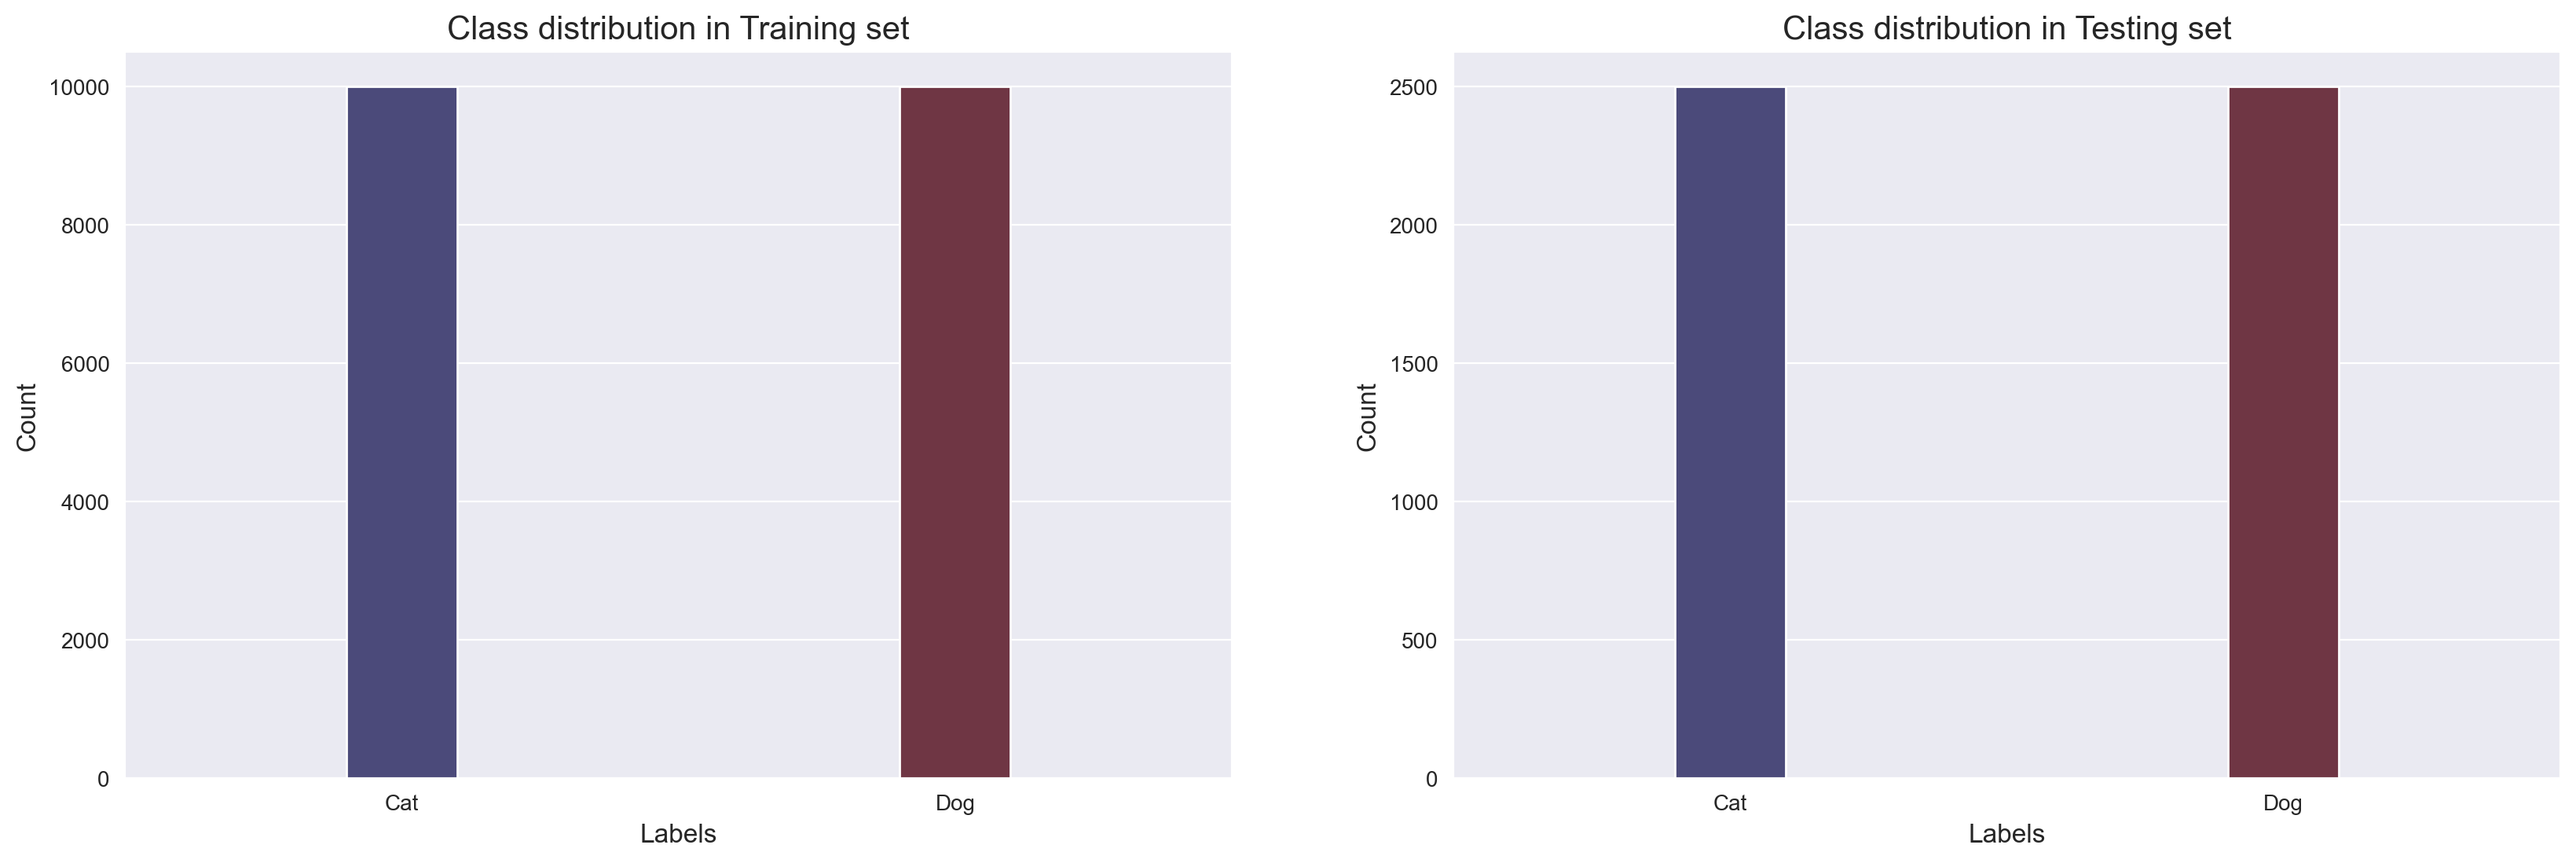

In [8]:
labels = ['Cat','Dog']

label1,count1 = np.unique(X_train.label,return_counts=True)
label2,count2 = np.unique(X_test.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])


plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(122)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

In [9]:
# parameters
image_size = 128 # Size of the image
image_channel = 3 # Colour scale (RGB)
bat_size = 32 # Number of files/images processed at once

In [10]:
# Creating image data generator
# Preprocess images ==> Feature Engineering for Images
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Applying image data gernerator to train and test data

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = 'C:/Users/zhaox/Northwestern HW/CatDog/train/',
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )


test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = 'C:/Users/zhaox/Northwestern HW/CatDog/train/',
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
# train_gen = train_datagen.flow_from_directory('C:/Users/zhaox/Northwestern HW/CatDog/train/', 
#                                               class_mode='binary',
#                                               target_size = (image_size,image_size),
#                                               batch_size = bat_size,
#                                              )

# test_gen = test_datagen.flow_from_directory('C:/Users/zhaox/Northwestern HW/CatDog/train/', 
#                                           class_mode='binary',
#                                           batch_size = bat_size,
#                                           target_size = (image_size,image_size),
#                                           shuffle = False
#                                          )

## Modeling

In [12]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='softmax')) # Softmax for binary classification

model.summary()

C:\Users\zhaox\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      29,491,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,514,562 (112.59 MB)

 Trainable params: 29,513,346 (112.58 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.1,
                                            min_lr = 0.00001,
                                            verbose = 1)

# early_stoping = EarlyStopping(monitor='val_loss',patience= 2,restore_best_weights=True,verbose=0)

In [14]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
cat_dog = model.fit(train_generator,
                    validation_data = test_generator, 
                    callbacks=[learning_rate_reduction],
                    epochs = 15,
                    # steps_per_epoch = len(train_generator),
                    # validation_steps = len(val_generaotor),
                   )

Epoch 1/15


C:\Users\zhaox\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 237ms/step - accuracy: 0.6487 - loss: 0.7349 - val_accuracy: 0.7208 - val_loss: 0.5553 - learning_rate: 0.0010
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 201ms/step - accuracy: 0.7567 - loss: 0.5051 - val_accuracy: 0.6628 - val_loss: 0.6385 - learning_rate: 0.0010
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 198ms/step - accuracy: 0.8063 - loss: 0.4213 - val_accuracy: 0.7634 - val_loss: 0.4827 - learning_rate: 0.0010
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - accuracy: 0.8581 - loss: 0.3316 - val_accuracy: 0.7948 - val_loss: 0.4549 - learning_rate: 0.0010
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - accuracy: 0.8965 - loss: 0.2562 - val_accuracy: 0.7956 - val_loss: 0.4775 - learning_rate: 0.0010
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 198ms/step - accuracy: 0.9325 - loss: 0.1760 - val_accuracy: 0.7684 - val_loss: 0.6664 - learning_rate: 0.0010
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9499 - 

In [16]:
cat_dog.history

{'accuracy': [0.687250018119812,
  0.7623000144958496,
  0.8069499731063843,
  0.8486499786376953,
  0.8931499719619751,
  0.9268500208854675,
  0.9441499710083008,
  0.9574000239372253,
  0.9650499820709229,
  0.9715499877929688,
  0.973550021648407,
  0.9761999845504761,
  0.9761000275611877,
  0.979200005531311,
  0.9804999828338623],
 'loss': [0.6284269690513611,
  0.494020015001297,
  0.4199835956096649,
  0.34429848194122314,
  0.2616821825504303,
  0.18631108105182648,
  0.14645017683506012,
  0.12000100314617157,
  0.10394812375307083,
  0.08940692245960236,
  0.0819661095738411,
  0.0765935406088829,
  0.07462987303733826,
  0.06912492960691452,
  0.06619978696107864],
 'val_accuracy': [0.72079998254776,
  0.6628000140190125,
  0.7634000182151794,
  0.7947999835014343,
  0.7955999970436096,
  0.7684000134468079,
  0.6656000018119812,
  0.8091999888420105,
  0.8145999908447266,
  0.8151999711990356,
  0.8140000104904175,
  0.8167999982833862,
  0.8172000050544739,
  0.818199992

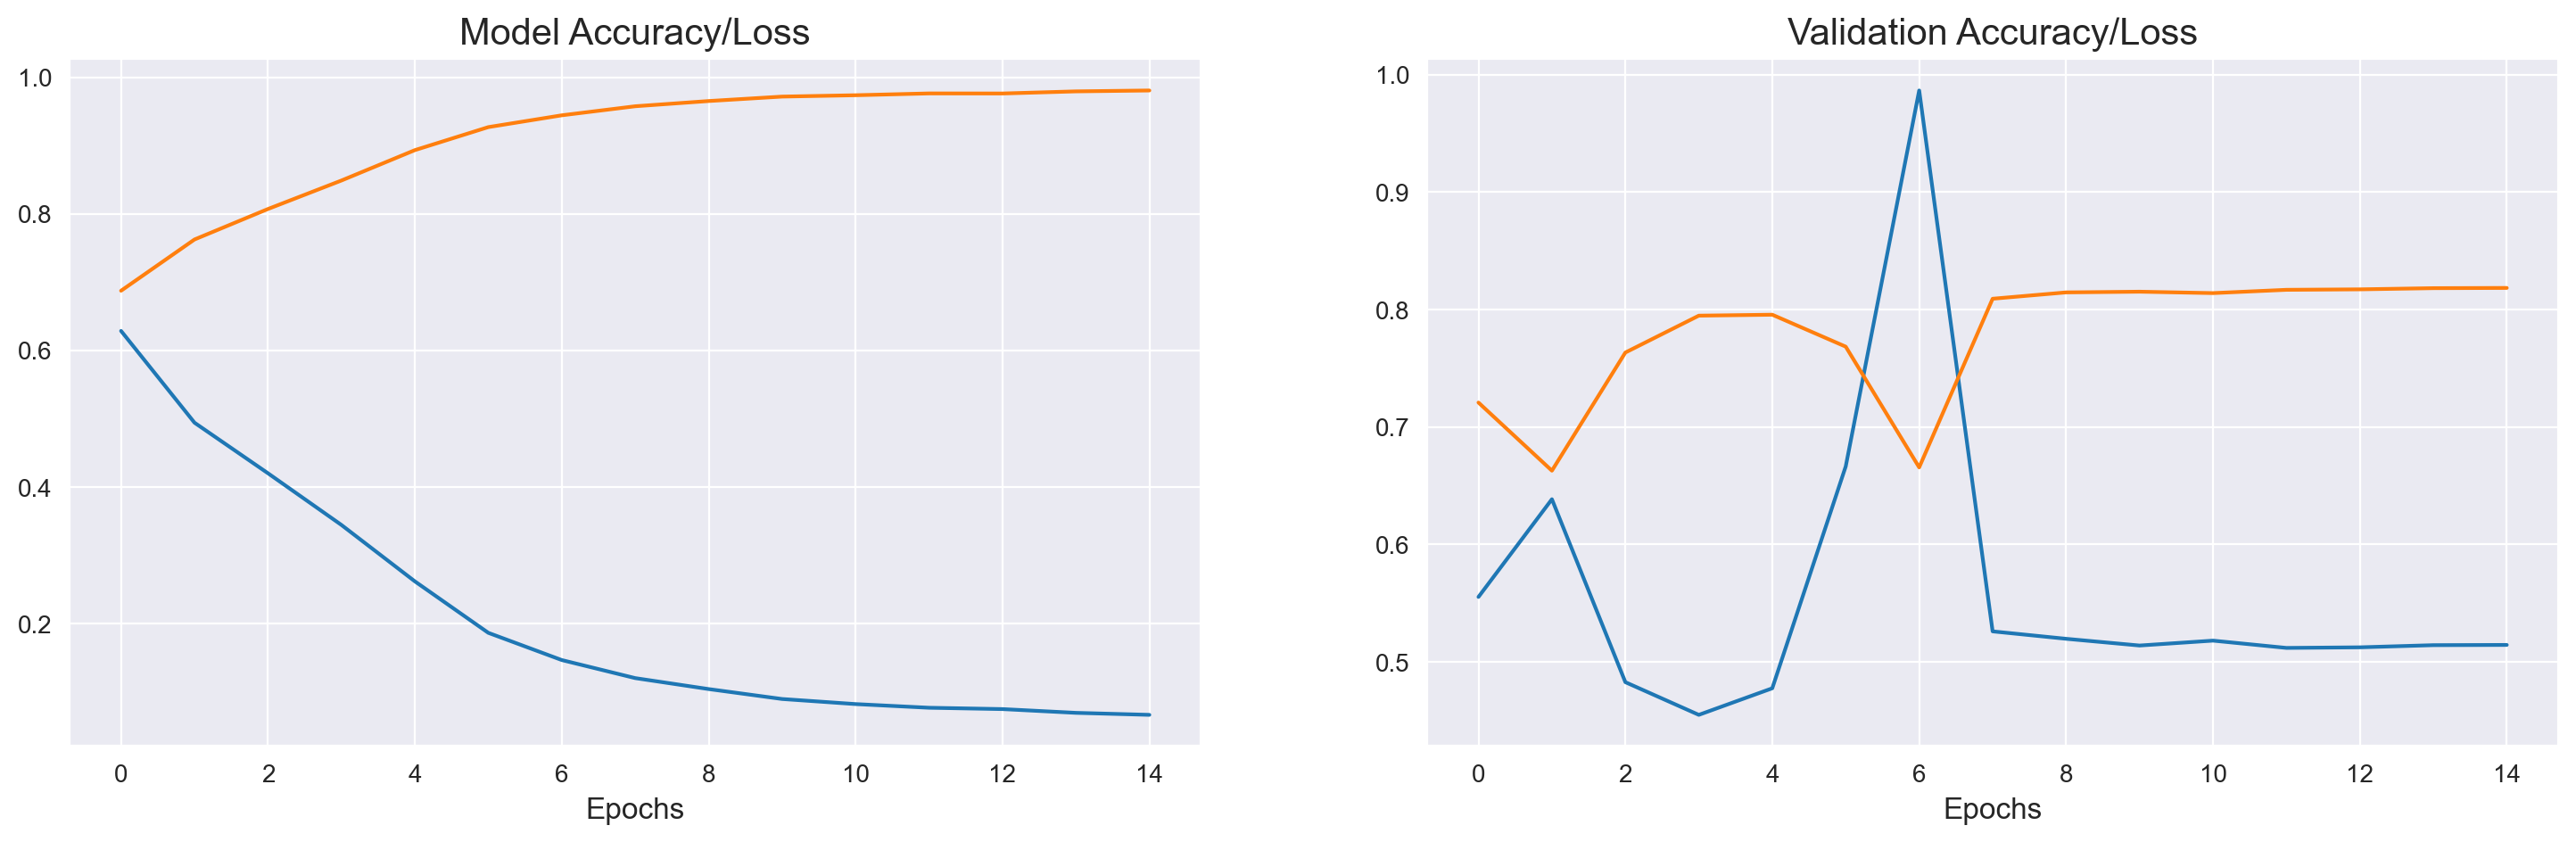

In [17]:
error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Model Accuracy/Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['accuracy'])

plt.subplot(122)
plt.title('Validation Accuracy/Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.plot(error['val_loss'])
plt.plot(error['val_accuracy'])

plt.show()

## Evaluation

In [18]:
# Evaluate for train generator
loss,acc = model.evaluate(train_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(test_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for test data is:',acc*100)
print('The Loss of the model for test data is:',loss)

The accuracy of the model for training data is: 99.78500008583069
The Loss of the model for training data is: 0.022451674565672874
The accuracy of the model for test data is: 81.84000253677368
The Loss of the model for test data is: 0.5144171118736267


In [19]:
# Save the Model
model.save("model.keras")

In [20]:
# prediction
result = model.predict(test_generator,batch_size = bat_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluate
loss,acc = model.evaluate(test_generator, batch_size = bat_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 81.84000253677368
The Loss of the model for testing data is: 0.5144171118736267


In [21]:
labels =['Cat','Dog']
print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

         Cat       0.80      0.86      0.82      2500
         Dog       0.84      0.78      0.81      2500

    accuracy                           0.82      5000
   macro avg       0.82      0.82      0.82      5000
weighted avg       0.82      0.82      0.82      5000



## Batch Processing Predict

In [49]:
# Function to load and preprocess images
def preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


import cv2
def pred_single(path):
    img = imread(path)
    
    rescaled_image = preprocess_image(img_path, target_size=(128, 128))
    
    rescaled_image /= 255.0
    # Make predictions
    predictions = model.predict(rescaled_image)
    
    # Assuming you have binary classification, extract the class with the highest probability
    predicted_class = np.argmax(predictions)
    
    if predicted_class == 0:
        pred = 'cat'
    else:
        pred='dog'
        
    return [img, pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


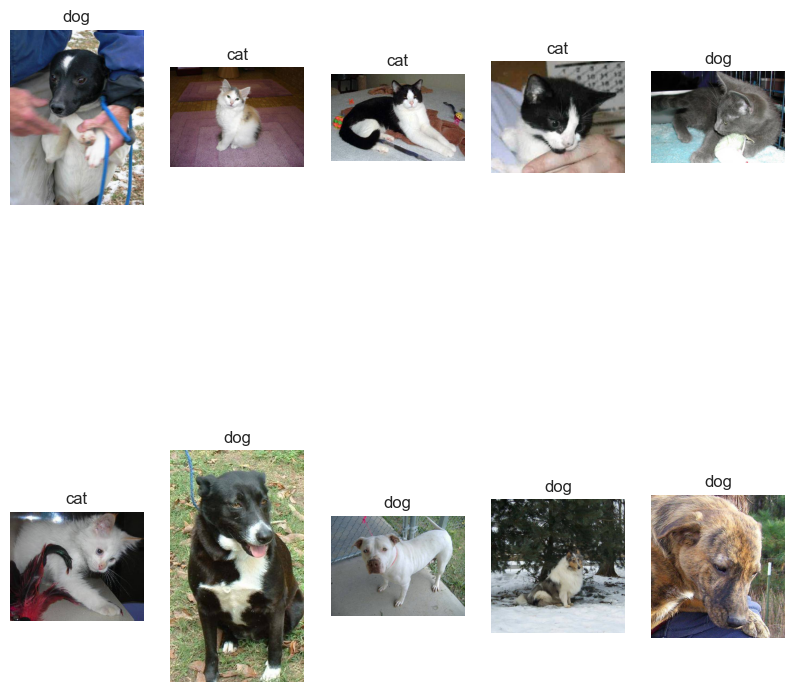

In [50]:
test = 'C:/Users/zhaox/Northwestern HW/CatDog/test'


imgs = []
preds = []

for index in [1, 10, 20, 50, 100, 500, 1000, 5000, 7500, 10000]:
    img_path = test + '/' + str(index) + '.jpg'
    
    output = pred_single(img_path)
    
    imgs.append(output[0])
    preds.append(output[1])
    
    
plt.figure(figsize=(10,10)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):
    
    plt.subplot(2, 5,i+1)    # the number of images in the grid is 10*10 (100)
    plt.imshow(imgs[i])
    plt.title(f'{preds[i]}',fontsize=12)
    plt.axis('off')

plt.show()

In [26]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Set up paths
test_data_dir = 'C:/Users/zhaox/Northwestern HW/CatDog/test'

# Load and preprocess test images
test_images = []
image_ids = []
for img_file in os.listdir(test_data_dir):
    img_path = os.path.join(test_data_dir, img_file)
    img_id = img_file.split('.')[0]  # Extract image ID from filename
    img = preprocess_image(img_path)
    test_images.append(img)
    image_ids.append(img_id)
test_images = np.vstack(test_images)

# Rescale the test images
test_images /= 255.0

In [37]:
# Predict probabilities for being a dog for each test image
probabilities = model.predict(test_images)

# Output image IDs and probabilities of being a dog
output = [(img_id, prob[1]) for img_id, prob in zip(image_ids, probabilities)]

# Print first few entries for demonstration
for img_id, prob_dog in output[:10]:
    print(f"Image ID: {img_id}, Probability of being a dog: {prob_dog}")

391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step
Image ID: 1, Probability of being a dog: 0.912966251373291
Image ID: 10, Probability of being a dog: 6.12250150879845e-05
Image ID: 100, Probability of being a dog: 0.5680259466171265
Image ID: 1000, Probability of being a dog: 0.999992847442627
Image ID: 10000, Probability of being a dog: 0.9997290968894958
Image ID: 10001, Probability of being a dog: 8.334402809850872e-05
Image ID: 10002, Probability of being a dog: 0.0003330996842123568
Image ID: 10003, Probability of being a dog: 0.8204399347305298
Image ID: 10004, Probability of being a dog: 0.015362096019089222
Image ID: 10005, Probability of being a dog: 0.00027356197824701667


In [44]:
upload = pd.DataFrame(output)
upload = upload.rename(columns={0:'id',1:'label'})
upload['id']=pd.to_numeric(upload['id'])
upload['label']=pd.to_numeric(upload['label'])
upload =upload.sort_values(by='id')
upload

,id,label
0,1,9.129663e-01
3612,2,9.998078e-01
4723,3,9.842787e-01
5834,4,9.999989e-01
6945,5,7.657635e-07
...,...,...
2775,12496,2.558426e-07
2776,12497,3.956699e-02
2777,12498,9.638325e-01
2778,12499,9.999770e-01


In [45]:
upload.to_csv('CNN_2.csv',index=False)